Dataset :
- url : https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224/data
- This dataset contain 1200 train images of roasted coffee beans with 300 for each class and 400 of test images with 100 for each class;
- The images have characteristic of one coffee beans taken close up with white background and some shadow.

# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenetv3

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Random seed
seed = 46

# Check TensorFlow version
print(tf.__version__)

# Check GPU Availibility
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.19.0
Num GPUs Available:  1


## Kaggle setup

In [ ]:
# Install Kaggle library in Google Collab

## Install Kaggle library
!pip install -q kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

# Data loading

In [ ]:
!kaggle datasets download gpiosenka/coffee-bean-dataset-resized-224-x-224

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224
License(s): CC-BY-SA-4.0
 80% 116M/144M [00:00<00:00, 1.19GB/s]
100% 144M/144M [00:00<00:00, 996MB/s] 


In [ ]:
# Unzip dataset
!unzip -qq ./coffee-bean-dataset-resized-224-x-224.zip

In [ ]:
main_path = '/content/'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

In [ ]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - Medium : 300
Total Data - Dark : 300
Total Data - Light : 300
Total Data - Green : 300

Test Path
Total Data - Medium : 100
Total Data - Dark : 100
Total Data - Light : 100
Total Data - Green : 100



# Exploratory data analysis

In [ ]:
# Function to visualize the first 20 images from each class

def plot_images(label):
  folder_path = os.path.join(train_path, label)
  fig = plt.figure(figsize=(10, 10))
  columns = 5
  rows = 4
  print('Class : ', label)
  images = os.listdir(folder_path)
  for index in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, index)
      image = plt.imread(os.path.join(folder_path, images[index]))
      plt.imshow(image)
      plt.axis("off")
  plt.show()

## Class `Green`

Class :  Green


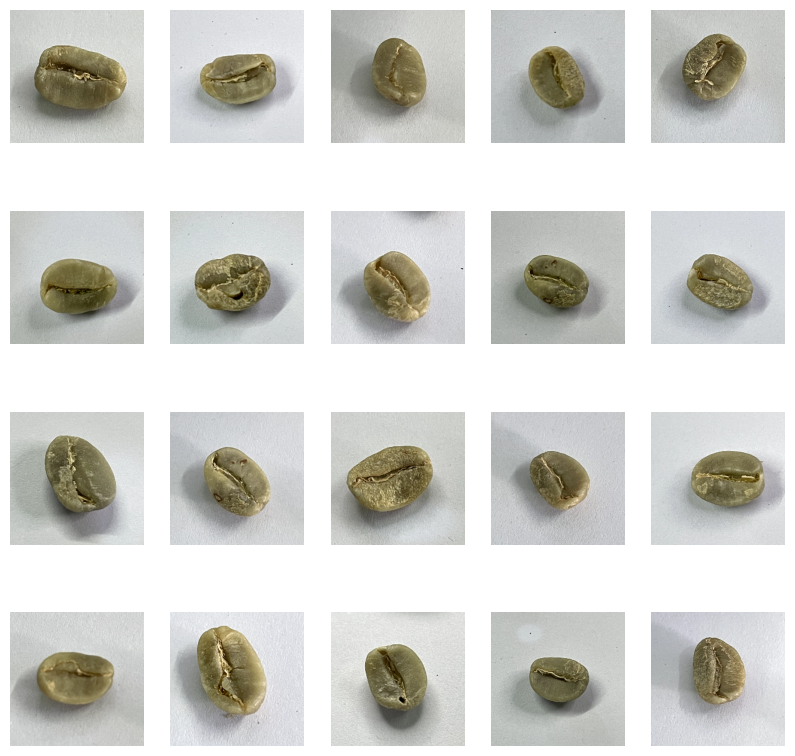

In [ ]:
# Visualization of first 20 image from class 'Green'
plot_images('Green')

## Class `Light`

Class :  Light


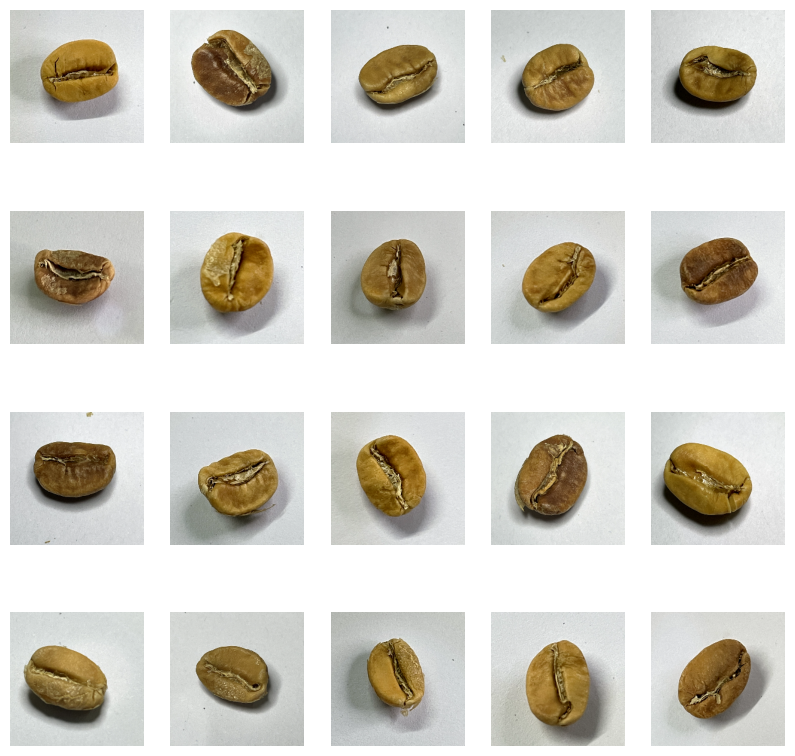

In [ ]:
# Visualization of first 20 image from class 'Light'
plot_images('Light')

## Class `Medium`

Class :  Medium


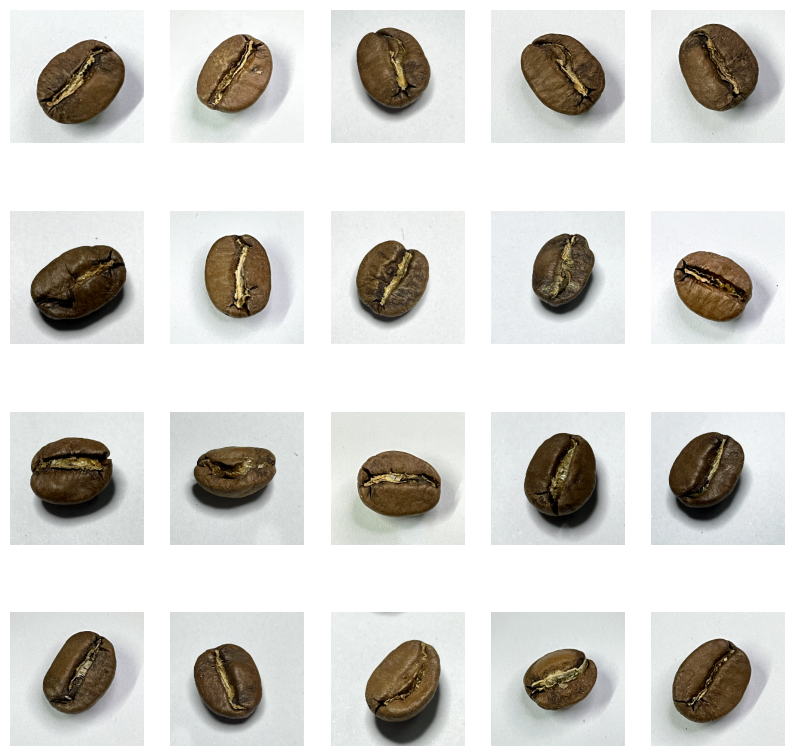

In [ ]:
# Visualization of first 20 image from class 'Medium'
plot_images('Medium')

## Class `Dark`

Class :  Dark


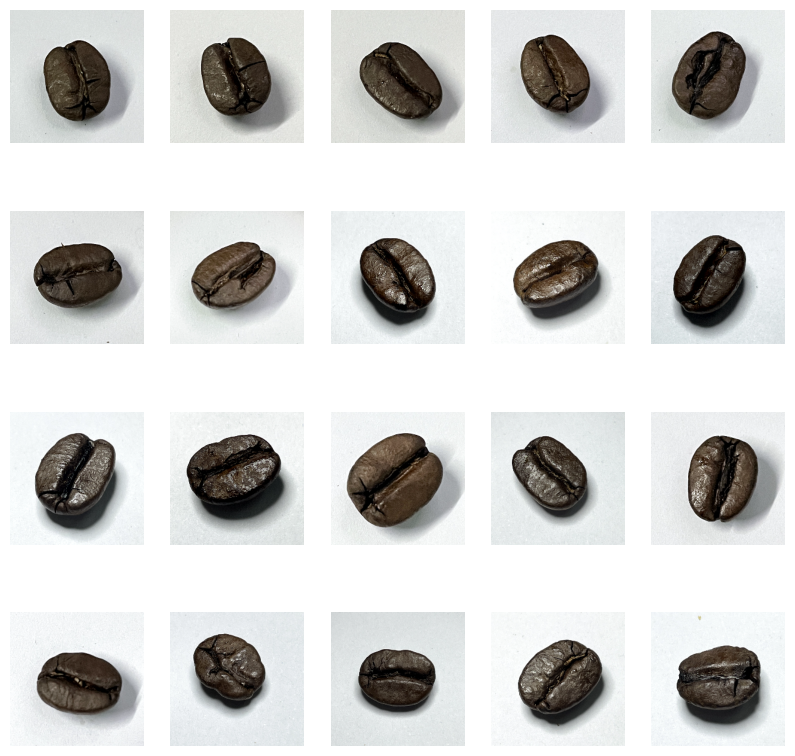

In [ ]:
# Visualization of first 20 image from class 'Dark'
plot_images('Dark')

## Exploratory conclusion

- The main difference of each class of coffee beans is it's color and the color of it's crack, while the shape of each class is similar;
- We guess that any color space used will give similar performance because of our image characteristic that able to be differentiate with it's color alone, all the images got one object in the middle (coffee beans) with white bacground and some shadow;
- In the wild, usually image of coffee beans is a full image filled with coffee beans, not a singular coffee beans with white background. So maybe our model will be a bit confused if it meet this kind of image in the future.

# Feature engineering

There will be no feature engineering other than `Image augmentation` will be done in this notebook, because :
- All image size is already uniform;
- All image class have the same characteristic, the clear distinction between them is their color.
  
So we think it's good enough to feed it directly to the model.

## Image augmentation

In [ ]:
# original image already at 224x224, so all the image augmentation will be done to this size
img_height= 224
img_width= 224
batch_size= 64

We will do augmentation with parameter as follow :
- Rescale → this will normalize all the pixel value into 0-1;
- Rotation → we will rotate the image randomly up to 270 degree, we do this because our image characteristic is almost all the same, so we hope that giving rotation will give a bit different viewpoint of the beans;
- Width and height shift → as stated before, our image characteristic is all the same, so we hope by giving the image width and height shift in augmentation will give a slighly different viewpoint of the beans.

In [ ]:
# parameter used on test and validation augmentation
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., # normalization all pixel value into 0-1
                                                                    rotation_range=270, # random image rotation up to 180 degree
                                                                    zoom_range=0.05, # random image zoom
                                                                    width_shift_range=0.05, # random image width shift
                                                                    height_shift_range=0.05, # random image height shift
                                                                    validation_split=0.4) # how much data splitted for validation set

# train data augmentation
train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=46)

# validation data augmentation
val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=46)

# test data will only be normalized without doing anything else
test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

# test set augmentation
test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=46)

Found 720 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# Training parameter

For ANN training we will use parameter as follow:
- Loss function : `sparse categorical corss entropy` → because our model will be trained to predict multiclass label
- Evaluation metrics : `accuracy` → we will predict what is the roasting type of the coffee beans, so we only care wether the prediction is correct or not

# ANN Training

## Model definition

In [ ]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4 because our data got 4 class target

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
history_aug = model.fit(train_set_aug,
                        epochs=20,
                        validation_data=val_set_aug,
                        batch_size=batch_size,
                        callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                        )

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2910 - loss: 9.0889 - val_accuracy: 0.4250 - val_loss: 1.2476
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5977 - loss: 1.0482 - val_accuracy: 0.7604 - val_loss: 0.6164
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8525 - loss: 0.4162 - val_accuracy: 0.9479 - val_loss: 0.1991
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9382 - loss: 0.1710 - val_accuracy: 0.8333 - val_loss: 0.3695
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9390 - loss: 0.1629 - val_accuracy: 0.8229 - val_loss: 0.4116
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9491 - loss: 0.1423 - val_accuracy: 0.9688 - val_loss: 0.1000
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9785 - loss: 0.0800 - val_accuracy: 0.8354 - val_loss: 0.4513
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9402 - loss: 0.1379 - val_accuracy: 0.9708 - val_loss:

## Model Evaluation

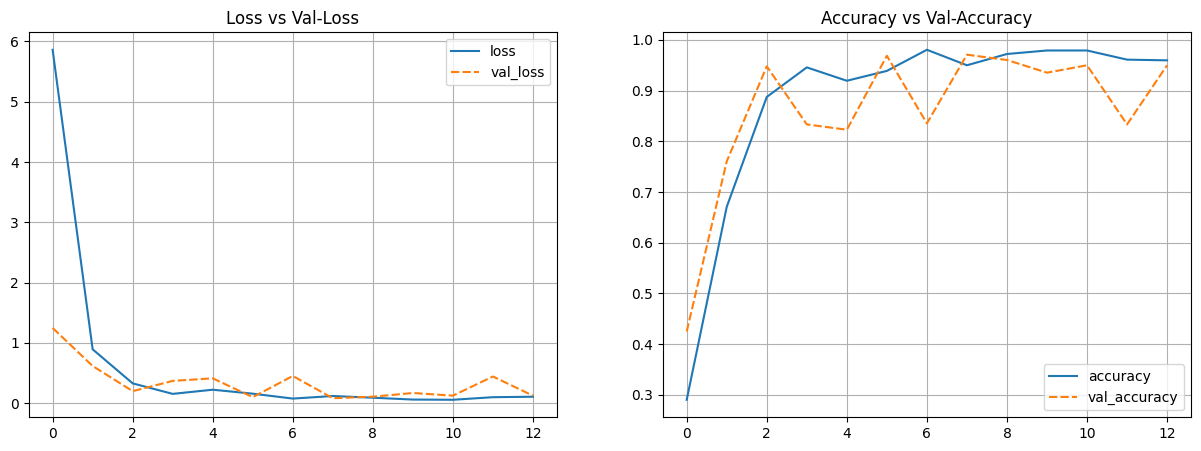

In [ ]:
history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The model have good performance and not overfitted, it scored 99% accuracy on the train set and 95% accuracy in the validation set, this performance is considered really good.

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model.predict(test_set_aug)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step
              precision    recall  f1-score   support

        Dark       1.00      0.83      0.91       100
       Green       1.00      0.98      0.99       100
       Light       0.98      1.00      0.99       100
      Medium       0.85      1.00      0.92       100

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



For the test set it give really good performance scored 97% overall with the details of:
- 97% for class `dark` which means 3 incorrect out of 100;
- 98% for class `green` which means 2 incorrect out of 100;
- 99% for class `light` which means 1 incorrect out of 100;
- 96% for class `medium` which means 4 incorrect out of 100;

# ANN Improvement

We will use MobileNetv3, the reason is because our objective is trying to help newbie coffee hobbyist that into coffee roasting to understand the type of roasted coffee easier, so we will have future objective to make application on smartphone to be able to use the model, hence `MobileNetv3` became the choice because of it `small size`.

## Preprocessing

In [ ]:
pretrained_model = MobileNetV3Large(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
pretrained_model.trainable = False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# parameter used on test and validation augmentation
train_datagen_mbnet = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., # normalization all pixel value into 0-1
                                                                    rotation_range=270, # random image rotation up to 180 degree
                                                                    zoom_range=0.05, # random image zoom
                                                                    width_shift_range=0.05, # random image width shift
                                                                    height_shift_range=0.05, # random image height shift
                                                                    validation_split=0.4, # how much data splitted for validation set
                                                                    preprocessing_function=preprocess_input_mobilenetv3
                                                                    )

# train data augmentation
train_set_mbnet = train_datagen_mbnet.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=46)

# validation data augmentation
val_set_mbnet = train_datagen_mbnet.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=46)

test_datagen_mbnet = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input_mobilenetv3)

# test set augmentation
test_set_mbnet = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=46)

Found 720 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


## Model Definition

In [ ]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
model_mbnetv3 = Sequential()
model_mbnetv3.add(pretrained_model)
model_mbnetv3.add(Flatten())
model_mbnetv3.add(Dense(512, activation='relu'))
model_mbnetv3.add(Dense(4, activation='softmax'))

# Compile
model_mbnetv3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_mbnetv3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 47040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    24,084,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,083,396 (103.31 MB)

 Trainable params: 24,087,044 (91.88 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Model Training

In [ ]:
history_mobilev3 = model_mbnetv3.fit(train_set_mbnet,
                        epochs=20,
                        validation_data=val_set_mbnet,
                        batch_size=batch_size,
                        verbose=1,
                        callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                        )

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.3127 - loss: 6.6505 - val_accuracy: 0.3125 - val_loss: 1.8616
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4770 - loss: 1.3182 - val_accuracy: 0.6104 - val_loss: 0.6554
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6737 - loss: 0.5889 - val_accuracy: 0.7042 - val_loss: 0.6170
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7481 - loss: 0.5249 - val_accuracy: 0.6104 - val_loss: 0.7577
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7314 - loss: 0.5637 - val_accuracy: 0.6729 - val_loss: 0.6736
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7571 - loss: 0.5295 - val_accuracy: 0.7229 - val_loss: 0.5901
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8177 - loss: 0.4258 - val_accuracy: 0.7354 - val_loss: 0.5875
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7882 - loss: 0.4940 - val_accuracy: 0.7875 - val_loss:

## Model Evaluation

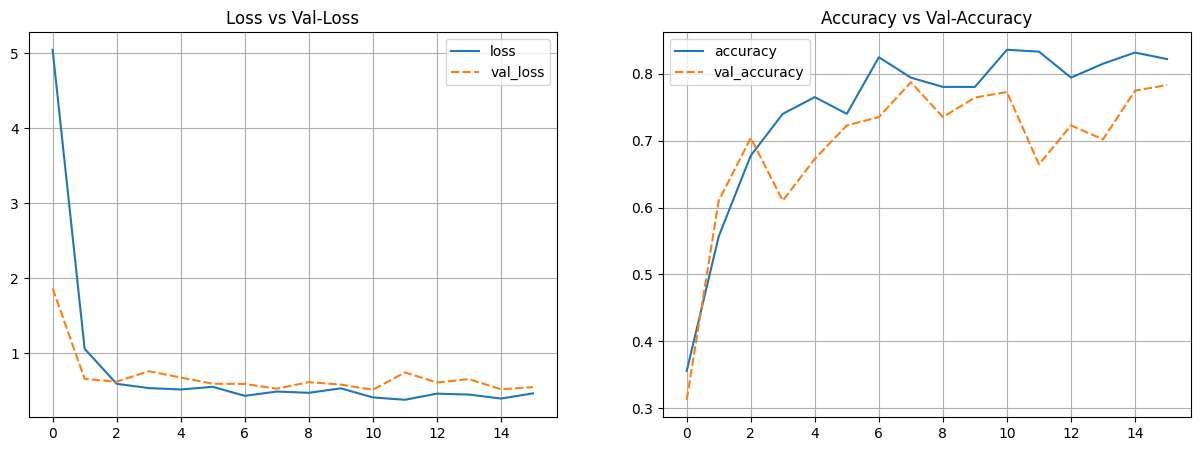

In [ ]:
history_mobilev3_df = pd.DataFrame(history_mobilev3.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_mobilev3_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_mobilev3_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The training history show that the model have stagnant loss that is low enough that it almost reach 0, but the accuracy say otherwise. The accuracy fluctuate with recognizeable value, it means the model reach it's plateau and tried to change it's weight so it can performed better, but the model can't find a better weight and stuck with it's training.

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_mbnet = model_mbnetv3.predict(test_set_mbnet)

## Get class with maximum probability
y_pred_class_mbnet = np.argmax(y_pred_prob_mbnet, axis=-1)

print(classification_report(test_set_mbnet.classes, y_pred_class_mbnet, target_names=np.array(list(train_set_mbnet.class_indices.keys()))))

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
              precision    recall  f1-score   support

        Dark       0.80      0.94      0.87       100
       Green       0.87      0.76      0.81       100
       Light       0.77      0.83      0.80       100
      Medium       0.86      0.76      0.81       100

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



For the test set it give decent performance scored 81% overall with the details of:
- 85% for class `dark` which means 15 incorrect out of 100;
- 84% for class `green` which means 16 incorrect out of 100;
- 77% for class `light` which means 23 incorrect out of 100;
- 77% for class `medium` which means 23 incorrect out of 100;

The model performed better for `dark` and `green` class, maybe because that class have the most distinct color feature compared to `light` and `medium`

# Model Saving

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

# Conclusion

Our new model that trained from 0 performed better in comparison with fine tuned MobileNetV3, this can happen because :
- The coffee beans image data have characteristic of one object on the middle of image(coffe beans) with white background and some shadow;
- The distinct feature of each roasted coffee beans that can be seen with naked eyes is only it's color;
- MobileNetV3 is pre-trained with imagenet dataset which have much more class and more color variation compared to our coffee beans image data, so the pre-trained weight isn't helping much;
- MobileNetV3 is much more smaller compared to our model, only at 2,996,352 parameter;
- Our model learned from 0, specialized to see our coffee beans image data that have it's distinct feature.

But eventhough MobileNetV3 performed worse compared to our model, it still give decent accuracy at 81% for test set with smaller size at around 100MB compared to our model at around 160MB, so it's still aligned with our objective.

For future improvement:
- We can feed more data with not only image that have one coffee beans in the middle, so when the model used to predict images that have full coffee beans without having background, the model won't get confused.
